# Behaviour cloning

This project is to experiment how to use neural network for regression where

* inputs: images captures when driving
* targets: how we control speed (throttle), steering and break

By fitting on training data, we expect that it can re-clone our behaviour. Let's load some module

In [1]:
# Load matplotib
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')  # emulates the aesthetics of ggplot (of R)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import cv2
import matplotlib.image as mpimg
import pandas as pd
import os

## Dataset
First, we try out the dataset provided by Udacity (can be downloaded from [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)). The dataset contains

* images captured by center/left & right camera
* a csv file `driving_log.csv` that contains image files with corresponding `sterring angle, throttle, brake, speed`

Let's load & visualize some samples

In [14]:
class DataConverter:
    def __init__(self, data_dir):
        self._data_dir = data_dir
    
    def __call__(self, text):
        return os.path.join(self._data_dir, text.strip())

udacity_dir = './data/0_udacity'    
udacity_dc = DataConverter(udacity_dir)
udacity_dlog = pd.read_csv(os.path.join(udacity_dir, 'driving_log.csv'), 
                           converters = {'left' : udacity_dc, 'right' : udacity_dc, 'center' : udacity_dc})

my_dir = './data/1_drive'
my_dc = DataConverter(my_dir)
my_dlog = pd.read_csv(os.path.join(my_dir, 'driving_log.csv'), 
                           converters = {'left' : my_dc, 'right' : my_dc, 'center' : my_dc})

my_recovery = './data/2_recovery'
my_rc = DataConverter(my_recovery)
my_rlog = pd.read_csv(os.path.join(my_recovery, 'driving_log.csv'), 
                           converters = {'left' : my_rc, 'right' : my_rc, 'center' : my_rc})

print('\n----------------------------')
print('Number udacity samples  {}'.format(udacity_dlog.shape[0]))

print(udacity_dlog[['left','center','right']].values[0])

driving_log = pd.concat([udacity_dlog, my_dlog, my_rlog], ignore_index=True)
print(driving_log[['left','center','right']].values[np.random.randint(driving_log.shape[0])])

driving_log.to_csv('./data/dataset.csv', index=False)


----------------------------
Number udacity samples  8036
['./data/0_udacity/IMG/left_2016_12_01_13_30_48_287.jpg'
 './data/0_udacity/IMG/center_2016_12_01_13_30_48_287.jpg'
 './data/0_udacity/IMG/right_2016_12_01_13_30_48_287.jpg']
['./data/0_udacity/IMG/left_2016_12_01_13_37_20_224.jpg'
 './data/0_udacity/IMG/center_2016_12_01_13_37_20_224.jpg'
 './data/0_udacity/IMG/right_2016_12_01_13_37_20_224.jpg']


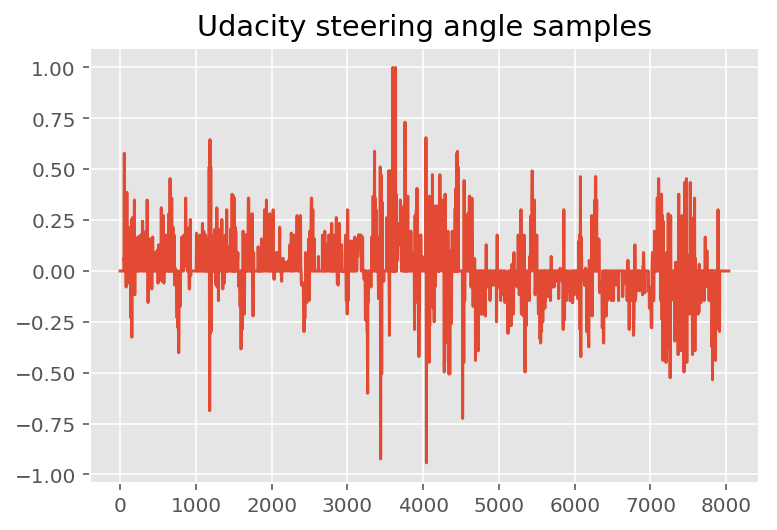

In [12]:
# check the steering angle through time
_ = plt.plot(udacity_dlog.index, udacity_dlog['steering'])
_ = plt.title('Udacity steering angle samples')

min angle -0.9426954
max angle 1.0
number of positive 1900
number of negative 1775
number of samples 8036


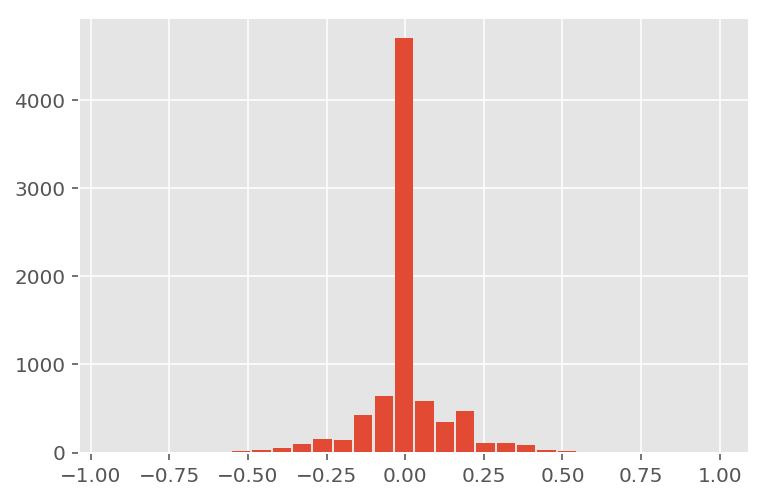

In [5]:
def steering_hist(steerings, num_bins = 30):
    # check the distribution of steering angle
    hist, bins = np.histogram(steerings, num_bins)
    width = 0.9 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    _ = plt.bar(center, hist, align='center', width=width)
    #plt.gca().set_yscale("log")
    print('min angle {}'.format(np.min(steerings)))
    print('max angle {}'.format(np.max(steerings)))
    print('number of positive {}'.format(len(np.where(steerings > 0)[0])))
    print('number of negative {}'.format(len(np.where(steerings < 0)[0])))
    print('number of samples {}'.format(len(steerings)))
    
steering_hist(udacity_dlog['steering'].values)    

min angle -1.0
max angle 1.0
number of positive 5027
number of negative 4536
number of samples 17368


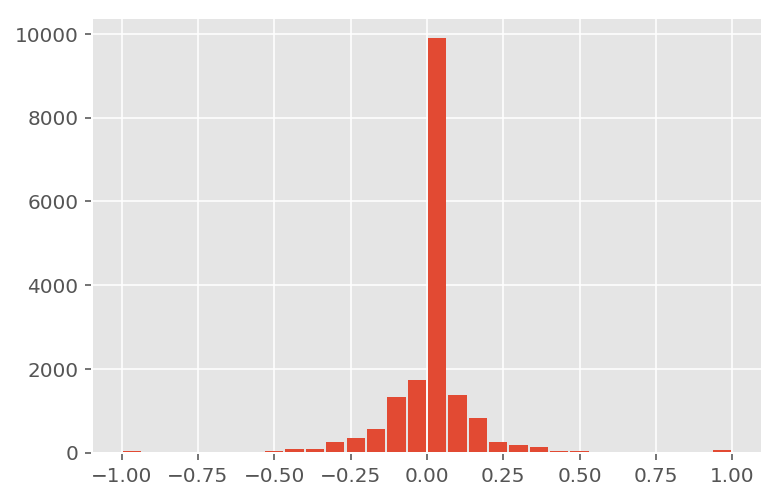

In [6]:
steering_hist(driving_log['steering'].values)  

Looking at above data, we notice

* steering angle is mostly 0
* steering angle is skewed to the right (positive angle)

In [32]:
def show_img(img, label, ax = None):
    '''
    this function show image & label
    '''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    # draw image
    if label is not None:
        ax.text(0, 0, label, color='k',backgroundcolor='c', fontsize=10)
    
    ax.imshow(img)
    ax.axis('off')

def add_steering_line(img, angle):    
    angle_to_rad = 25.0 * np.pi*angle/180.
    h, w = img.shape[:2]
    line_len = h/3
    x = int(w/2 + np.sin(angle_to_rad) * line_len)
    y = int(h - np.cos(angle_to_rad) * line_len)
    img_cpy = img.copy()
    cv2.line(img_cpy,(int(w/2),int(h)),(x, y),(0,255,0),thickness=4)
    return img_cpy
    
def view_imgs(imgs, labels, figsize, multi_col = True, sharex = True, sharey = True):
    nrows = 1 if multi_col else len(labels)
    ncols = len(labels) if multi_col else 1
    fig, axes = plt.subplots(figsize= figsize, nrows=nrows, ncols=ncols, sharey=sharex, sharex=sharey)
    for i, ax in enumerate(axes.flatten()):
        show_img(imgs[i], labels[i], ax)
    
def view_row(idx, data = udacity_dlog, figsize=(20,4)):
    img_cols = ['left', 'center', 'right']
    
    imgs = []
    for i,col in enumerate(img_cols):
        img = mpimg.imread(data[col][idx])
        # add a line represents speed + steering
        if i == 1:
            angle = data['steering'][idx]
            img = add_steering_line(img, angle)
            img_cols[i] += '-{:.2f}'.format(25.0 * angle)
        imgs.append(img)
        
    view_imgs(imgs, img_cols, figsize)

Let's visualize some images for training dataset

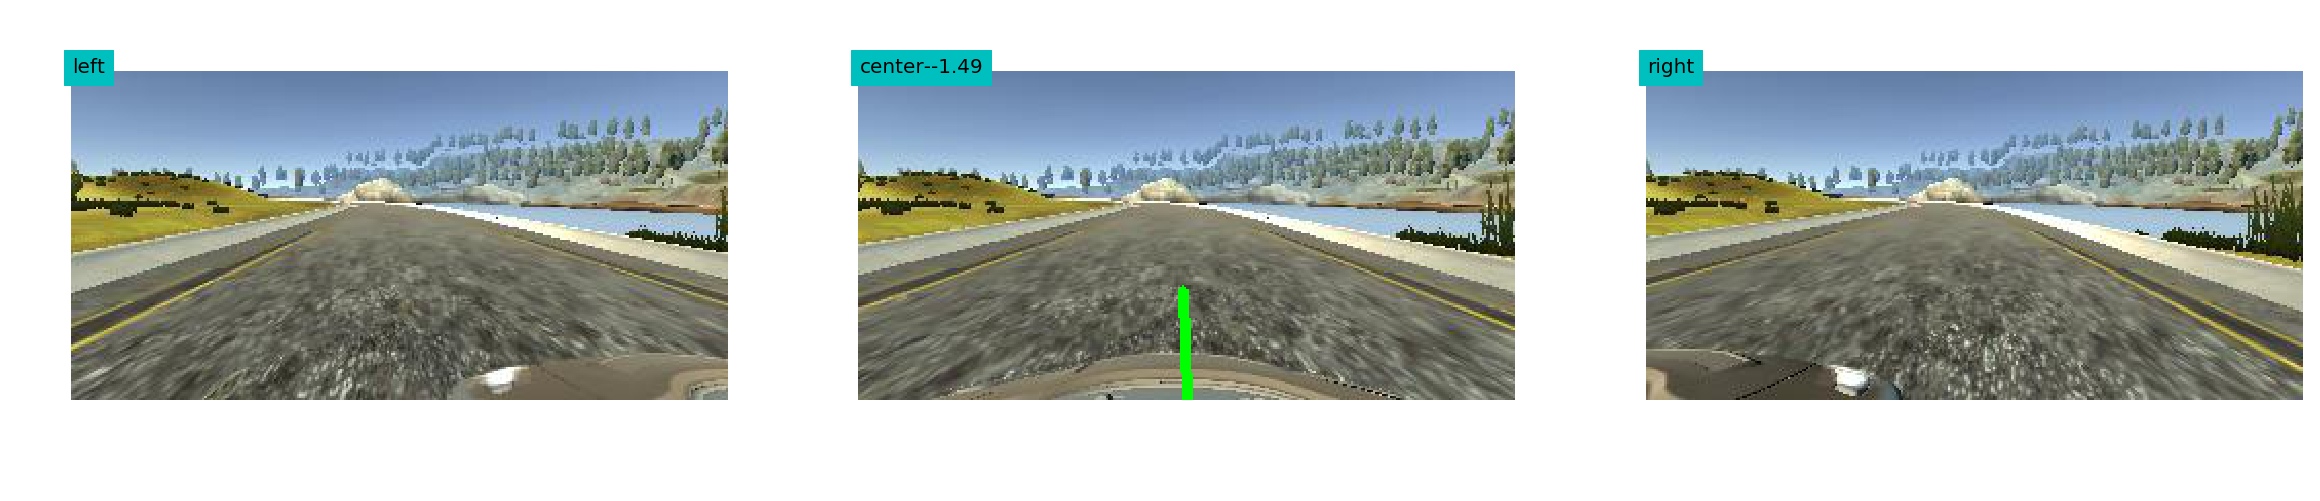

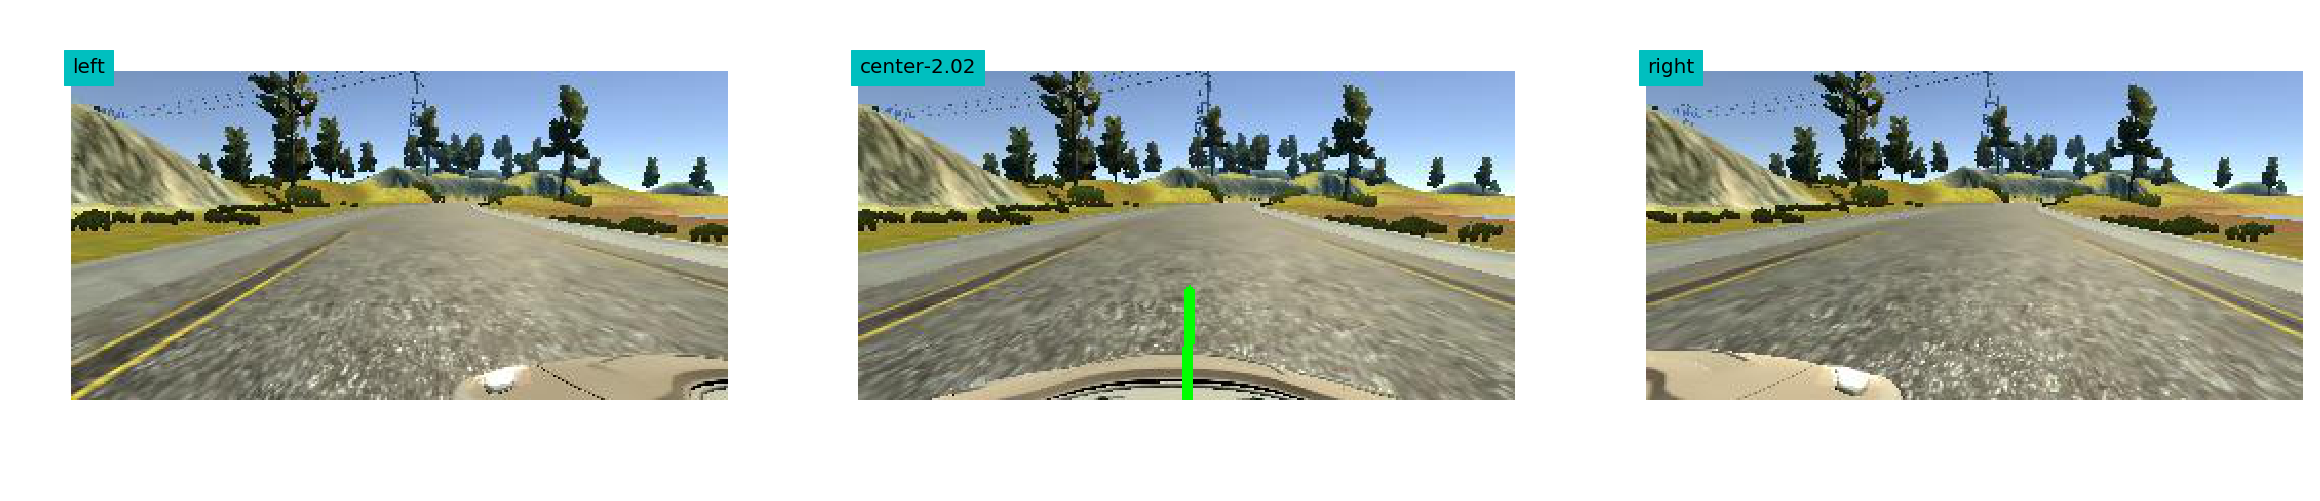

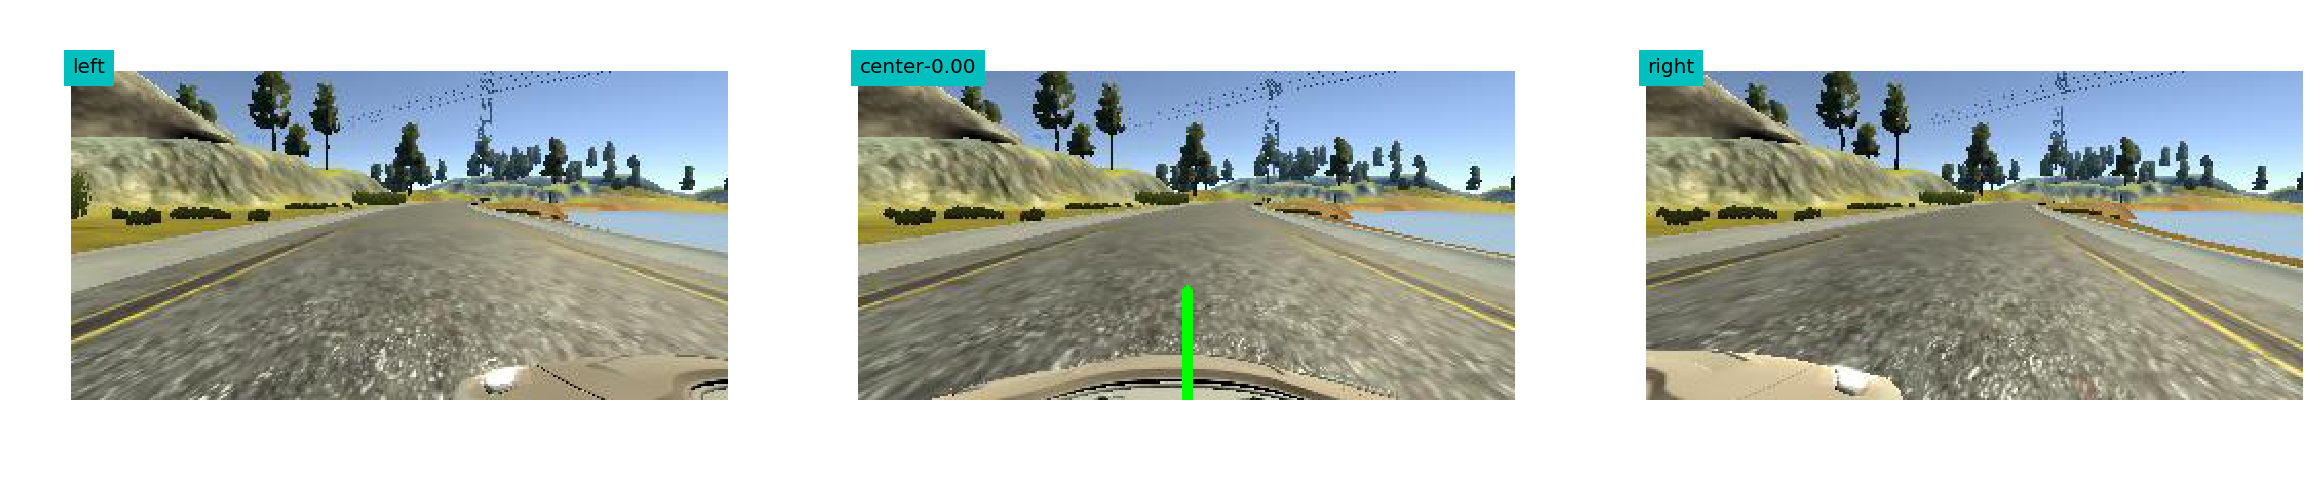

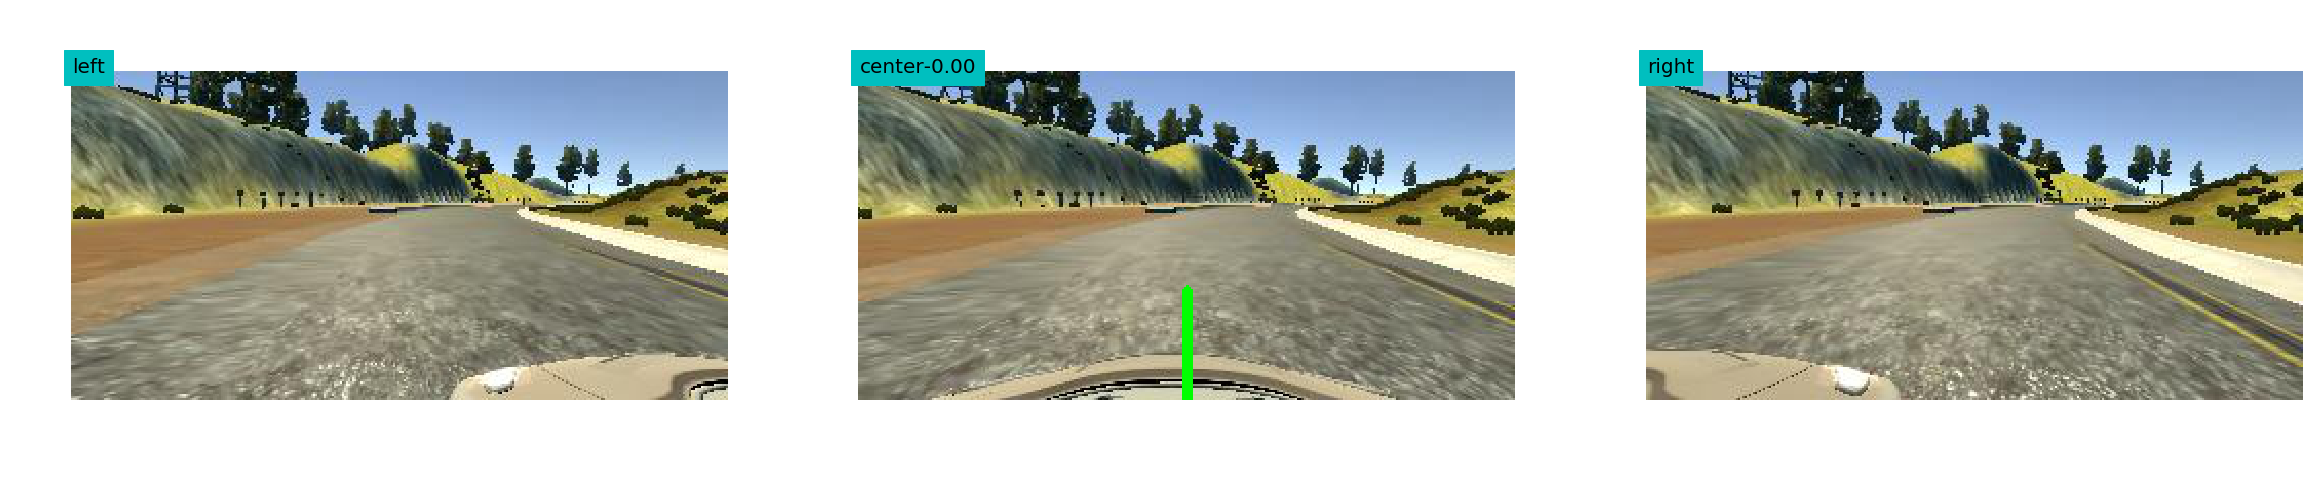

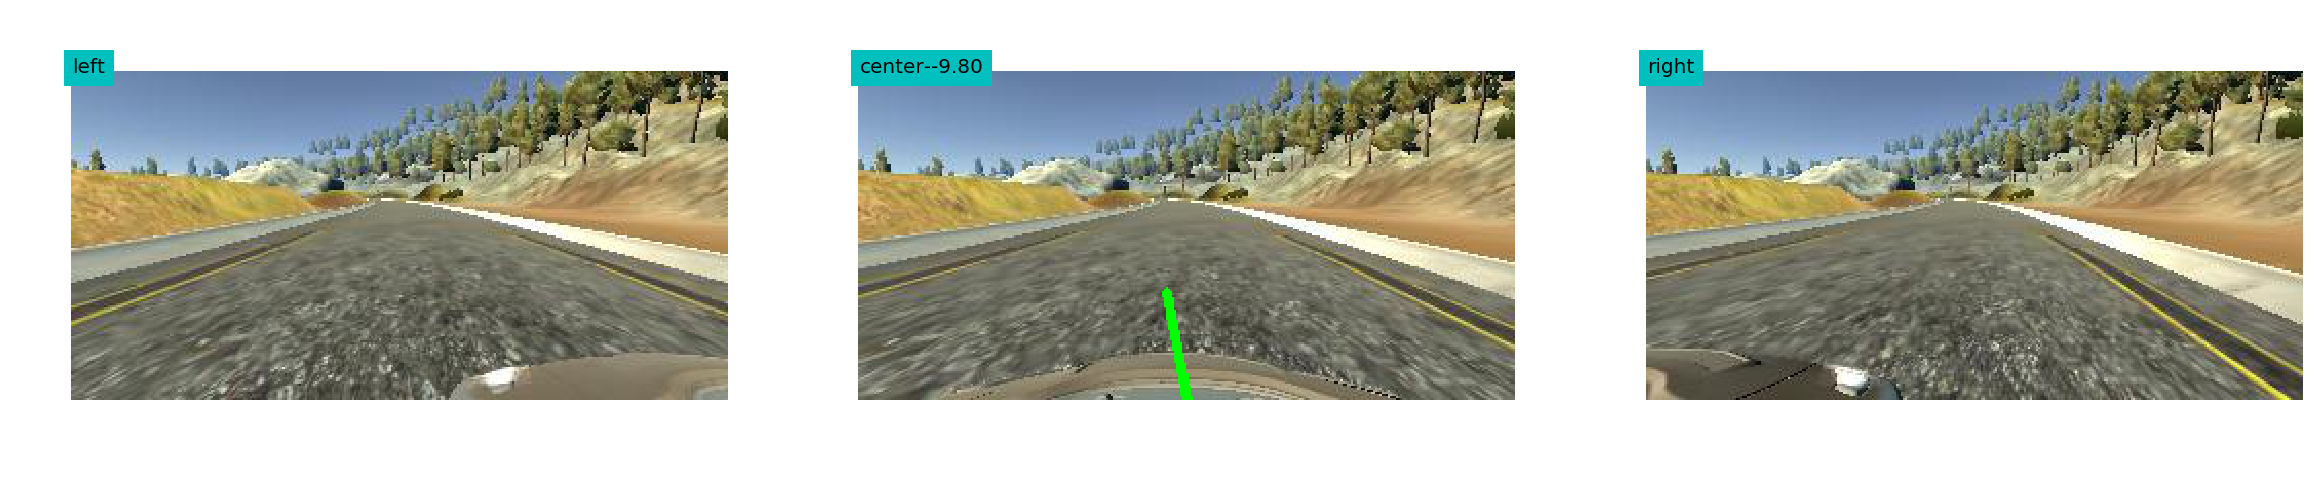

In [33]:
for i in range(5):
    view_row(np.random.randint(udacity_dlog.shape[0]))

## Data preprocessing

### Train/Validation dataset
Before looking at data preprocessing, let's first divide the data into train and validation with ratio (80/20). Here we don'thave use test-set since we will test the performance on the track

In [40]:
dataset = driving_log
train, valid = np.split(dataset.sample(frac=1, random_state = 45), [int(0.8* len(dataset))])

train = pd.DataFrame(train.values, columns=udacity_dlog.columns)
valid = pd.DataFrame(valid.values, columns=udacity_dlog.columns)
# append addition data to traininng


print('training-samples   {}'.format(train.shape[0]))
print('validation-samples {}'.format(valid.shape[0]))

training-samples   13894
validation-samples 3474


### Data normalization/cropping/resize

#### Cropping
Looking at input images, we notice the top of images contains tree/sky and the bottom of image contain a part of our car => this is not helpful so we crop it out (this is also suggested in the project page)

#### Resize
Since NVIDIA use input (H=66,W=200), we mimic the input for NVIDIA model

In [53]:
def crop(img, top, bottom): 
    return img[top:-bottom, :, :]

def resize(img, width, height):
    return cv2.resize(img, (width, height), cv2.INTER_AREA)

def preprocess(img, 
               crop_top = 60, 
               crop_bottom = 25,
               resize_width = 200,
               resize_height = 66):
    # crop img
    img = crop(img, crop_top, crop_bottom)
    
    # resize img
    img = resize(img, resize_width, resize_height)
    
    return img

def view_preprocess_img(idx, dataset = udacity_dlog, figsize=(20,10)):
    img = mpimg.imread(dataset['center'][idx])
    img_prep = preprocess(img)
    
    imgs = [img, img_prep]
    labels = ['original', 'preprocessed']
    
    view_imgs(imgs, labels, figsize, sharex = False, sharey = False)
    

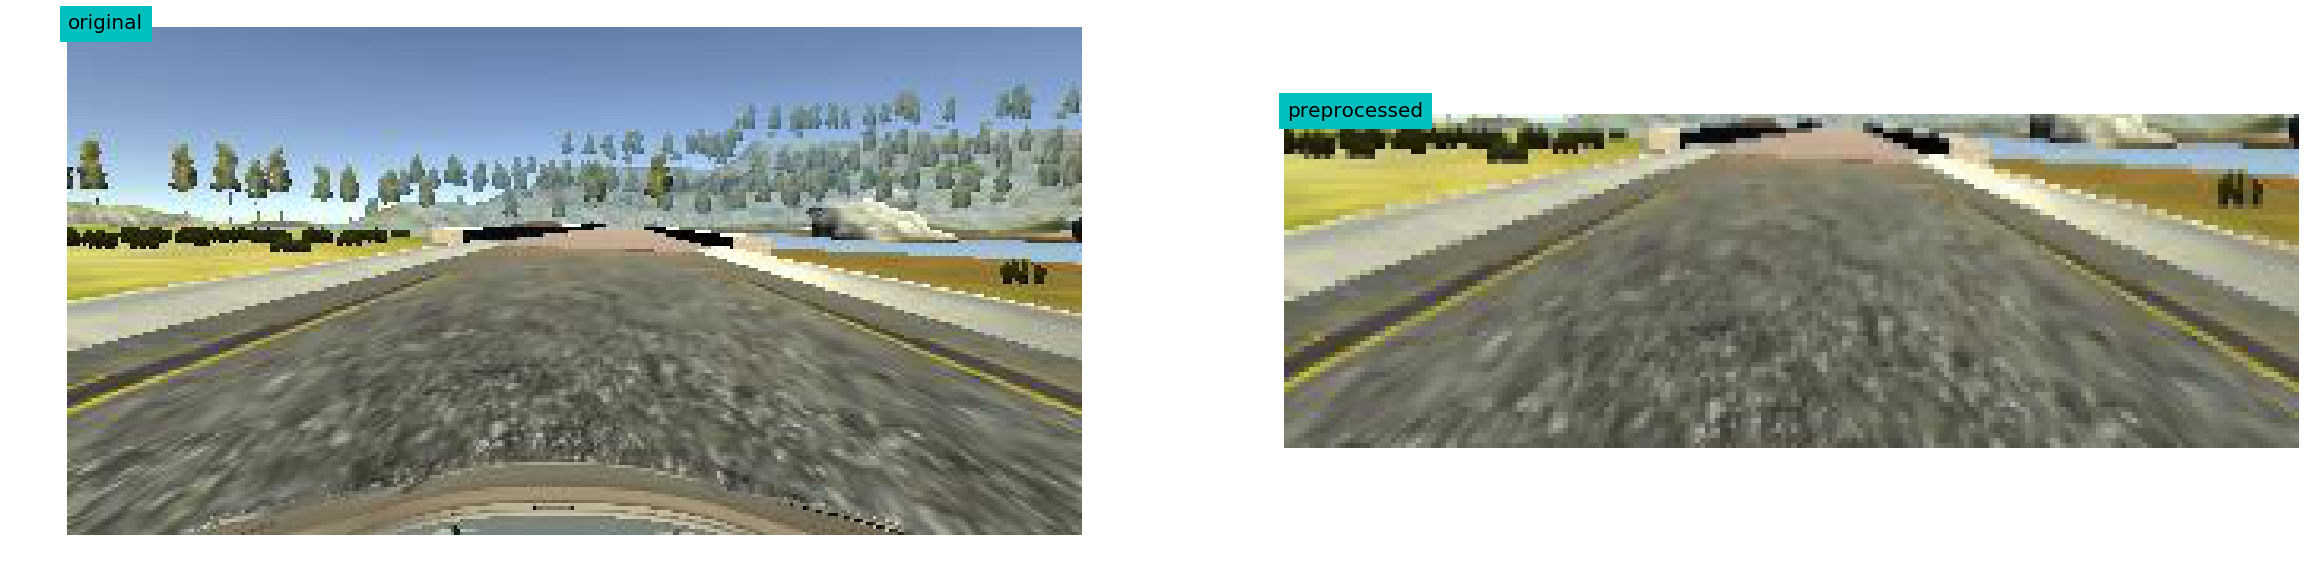

In [54]:
idx = np.random.randint(udacity_dlog.shape[0])
view_preprocess_img(idx)

### Data augmentation

Note that the training data given is very limited and skewed (more positive angle than negative one), this shows an indication that we need to augment training data. The following steps can be employ to generate more data

#### Multiple camera
As suggested from the project page
<center>
<img src="./assets/carnd-using-multiple-cameras.png" width="480">
</center>
formally :
* if we use left-camera steering_left = steering_center + correction
* if we use right-camera steering_right = steering_center - correction
    
where correction > 0 is a tunning parameters. 

In [15]:
def multiple_camera(left_center_right, steering, correction):
    lcr = np.random.choice(3)
    if lcr == 0:
        steering += correction
    elif lcr == 2:
        steering -= correction
        
    return left_center_right[lcr], steering

#### Flip image
Notice that data is skewed (more positive than negative). One can flip image horizontally + flip sign of steering angle this can help to solve the skewness in training data

#### Random shadow
We add a random shadow to a left or right domain 

#### Random brightness
We randomly changing the brightness so it can work on other track where images might be darker.

In [20]:
def random_flip(img, steering):
    if np.random.randint(2) == 0:
        return img, steering
    else:
        return np.fliplr(img), -steering

def random_shadow(img):
    H, W,_ = img.shape
    
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = 0, W * np.random.rand()
    x2, y2 = H, W * np.random.rand()
    
    xm, ym = np.mgrid[0:H, 0:W]

    # mask above the line to be 1
    mask = np.zeros((H, W))
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust Light
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # convert to HLS(Hue, Light, Saturation) then adjust Light
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

def random_brightness(img):
    # convert to HSV (Hue, Saturation, Value) where Value is for brightness.
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # randomly adjust brightness
    ratio = 0.5 + np.random.uniform()
    hsv[:,:,2] = ratio * hsv[:,:,2]
    hsv[:,:,2][hsv[:,:,2] > 255] = 255
    
    # convert back to RGB
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
def random_translate(img, steering, range_x, range_y):
    # see example from 
    #    http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    trans_x = range_x * (np.random.uniform() - 0.5)
    trans_y = range_y * (np.random.uniform() - 0.5)
    
    steering += trans_x * 0.002
    trans_matrix = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    H, W, _ = img.shape
    
    return cv2.warpAffine(img, trans_matrix, (W, H)), steering

def get_jittered_data(img, steering):
    img = mpimg.imread(img)
    
    # random flip
    img, steering = random_flip(img, steering)
        
    # random shadow
    img = random_shadow(img)
    
    # random brightness
    img = random_brightness(img)
    
    # random translate
    # img, steering = random_translate(img, steering, 80, 10)
    
    return img, steering

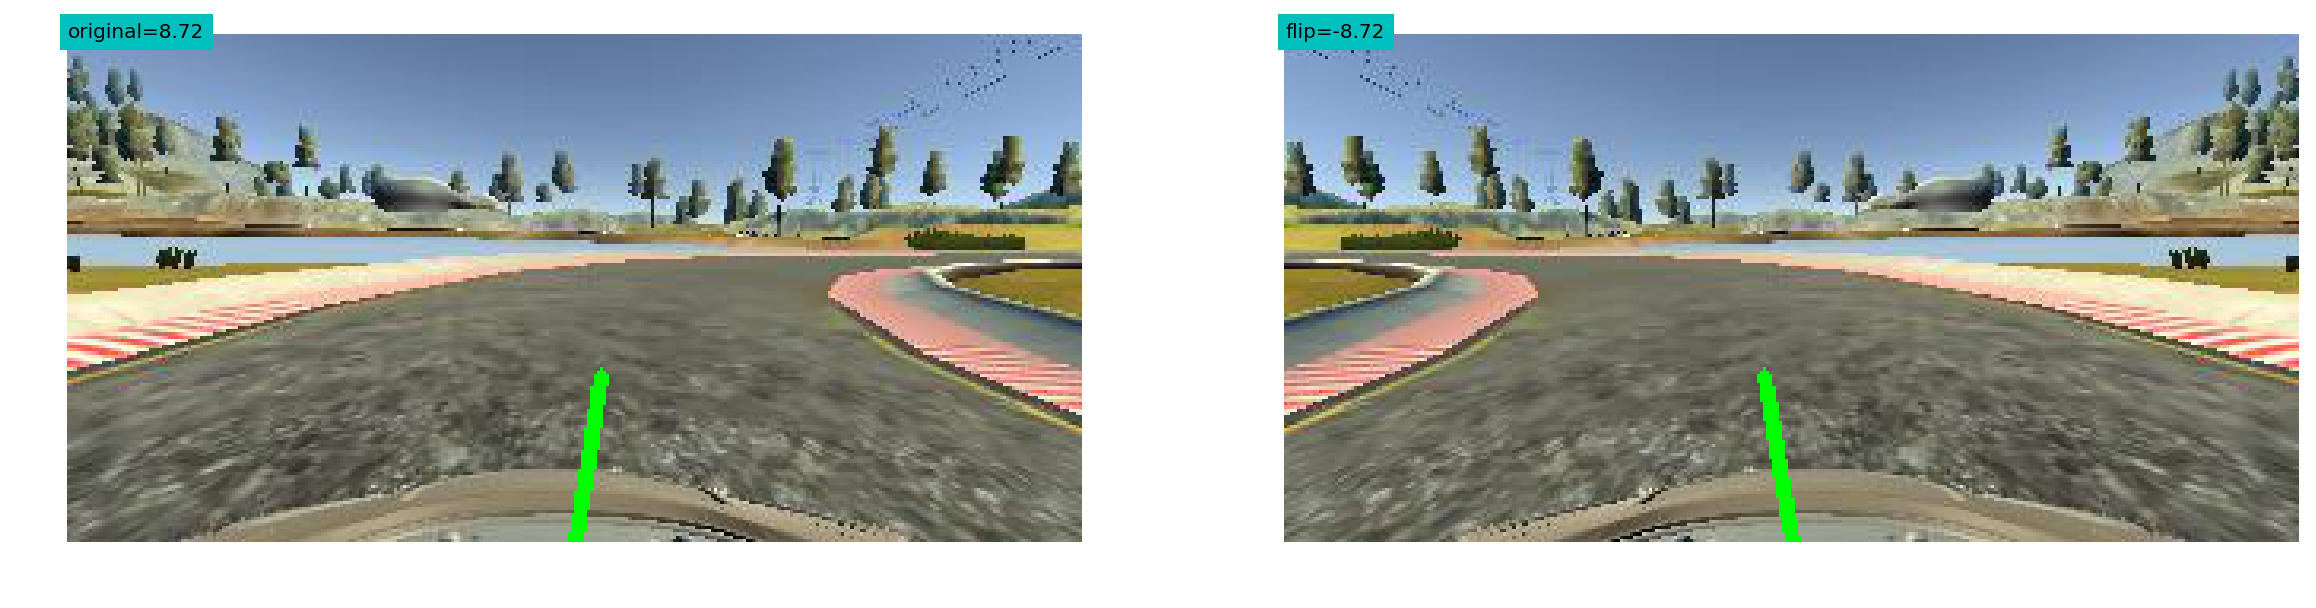

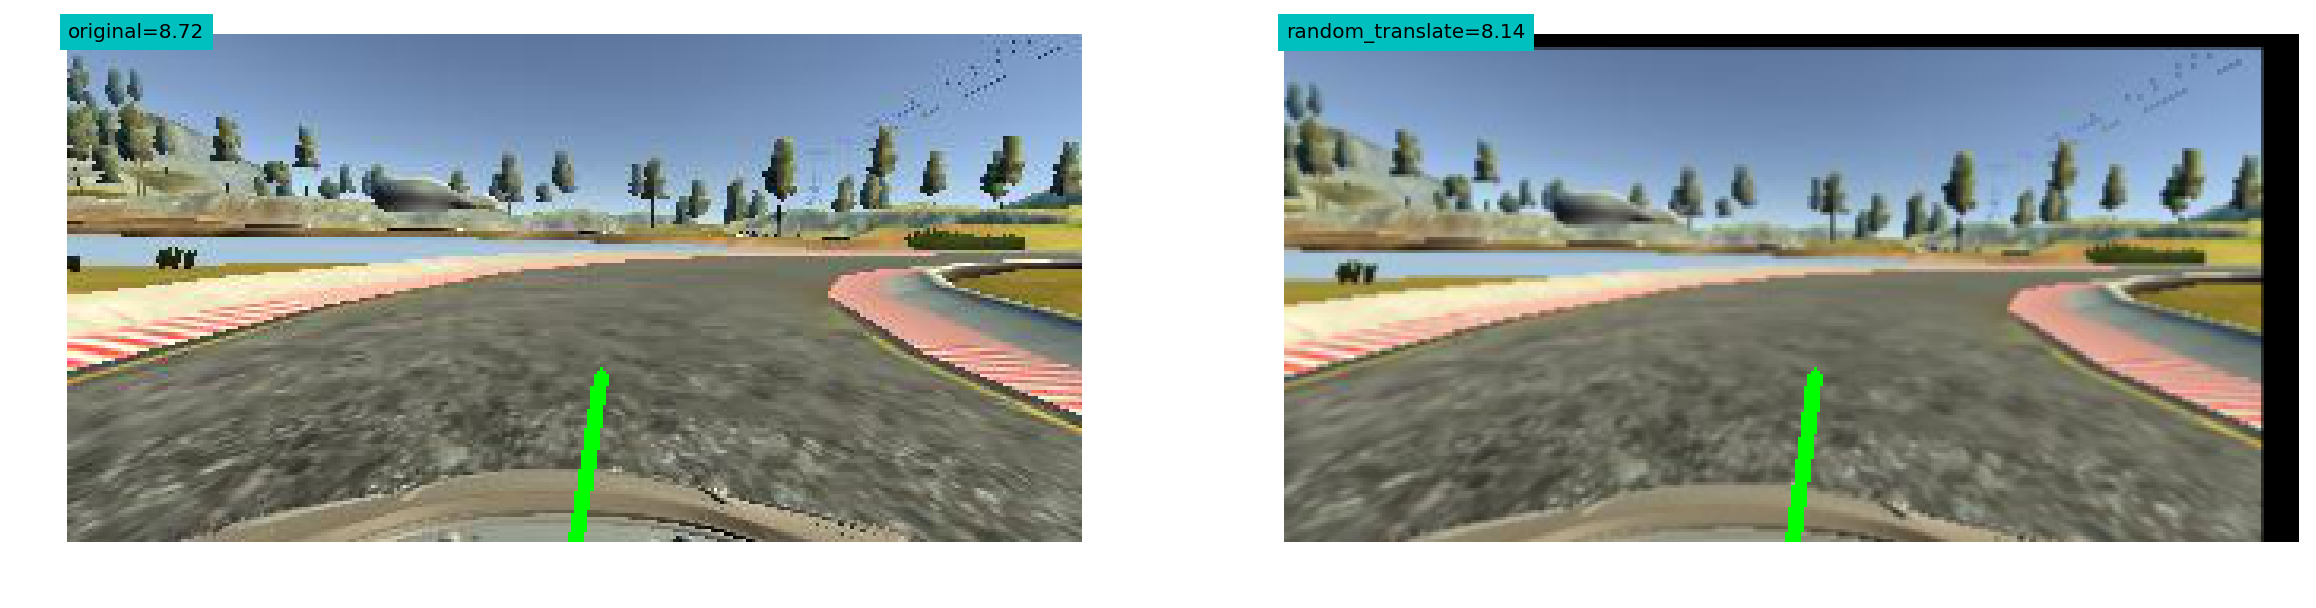

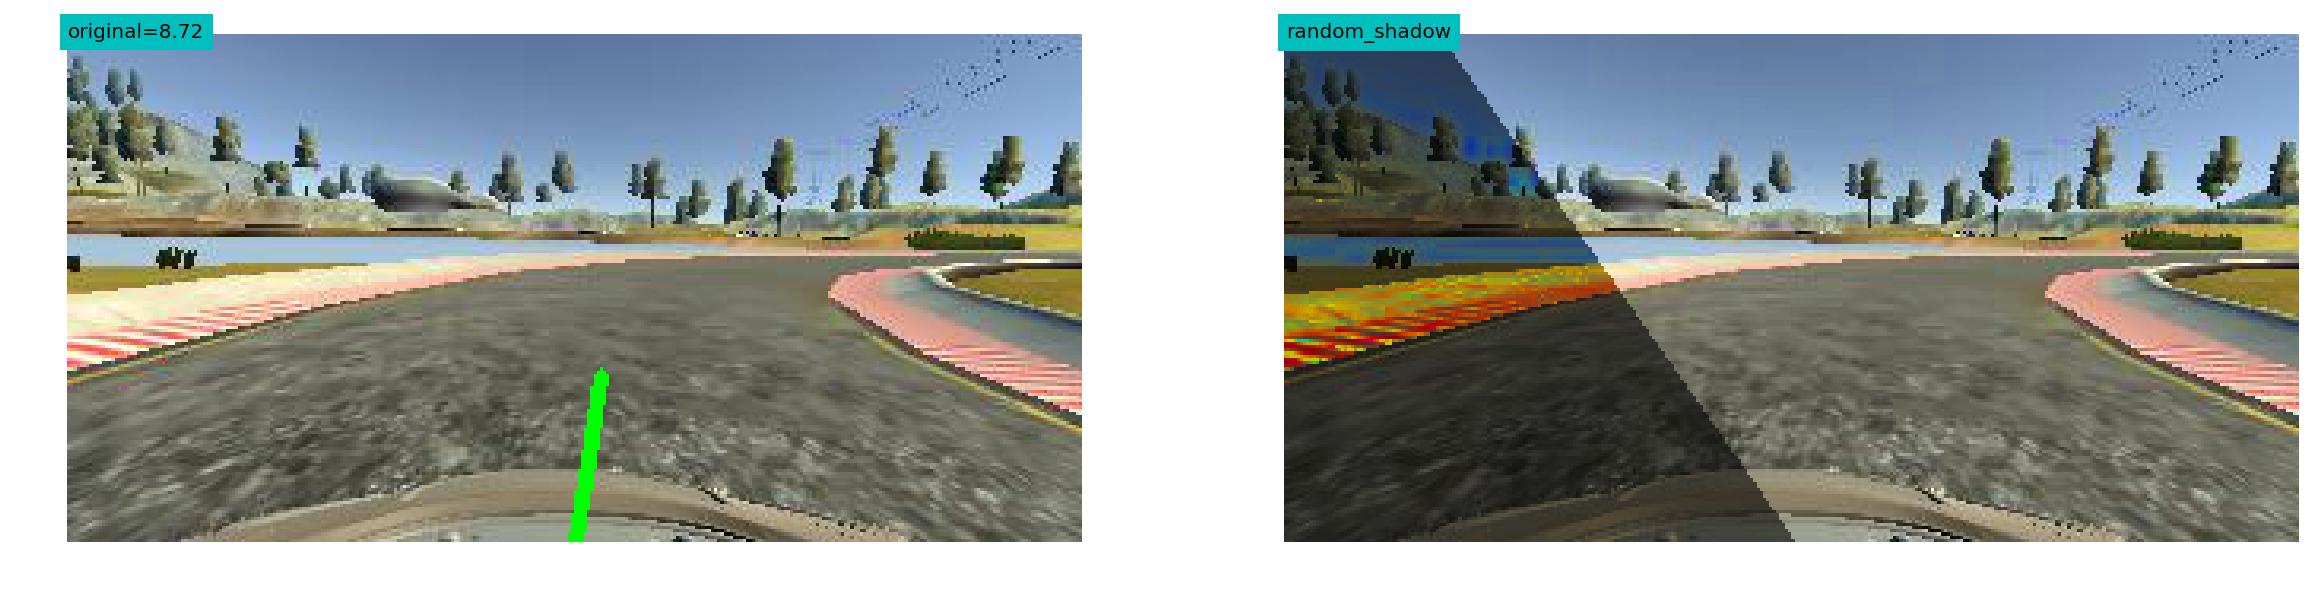

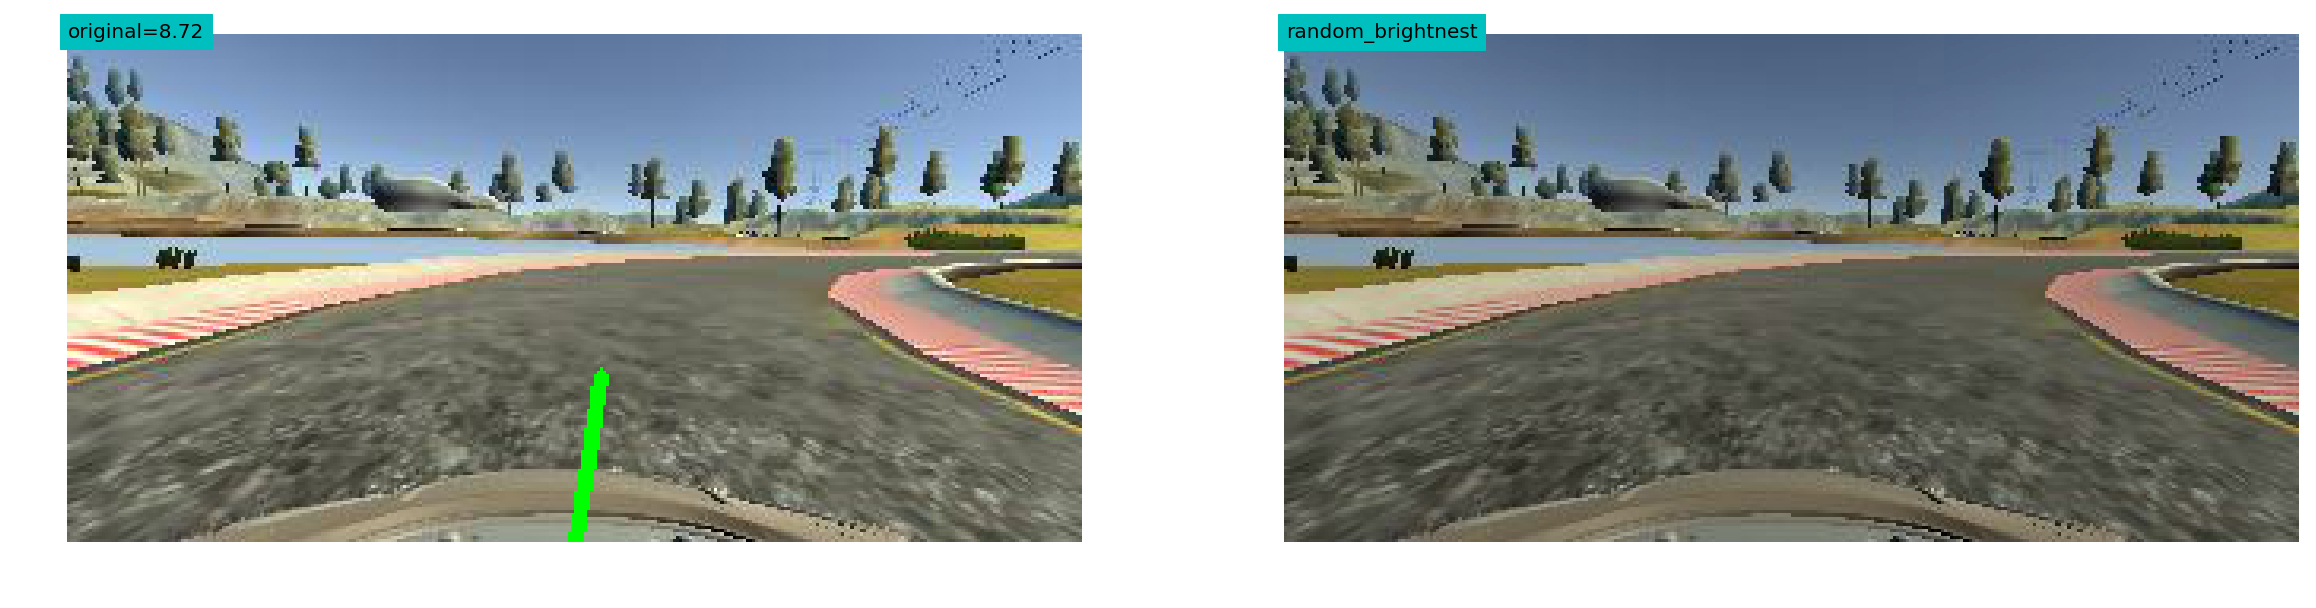

In [48]:
# test the function out
idx = np.random.randint(udacity_dlog.shape[0])
img, steering = udacity_dlog[['center', 'steering']].values[idx]

img = mpimg.imread(img)

img_flipped = np.fliplr(img)
img_translated, steering_translated = random_translate(img, steering, 80, 10)
img_shadow = random_shadow(img)
img_brightness = random_brightness(img)

img = add_steering_line(img, steering)
img_flipped = add_steering_line(img_flipped, -steering)
img_translated = add_steering_line(img_translated, steering_translated)
imgs   = np.array([img, img_flipped, img_translated, img_shadow, img_brightness])
labels = np.array(['original={:.2f}'.format(25*steering), 'flip={:.2f}'.format(-25*steering),
          'random_translate={:.2f}'.format(25*steering_translated), 'random_shadow', 'random_brightnest'])

for i in range(1, len(imgs)):
    view_imgs(imgs[[0, i]], labels[[0, i]], figsize=(20,5))

Let's visualize some random image side-by-side with original data

In [17]:
def visualize_aug(idx, dataset = udacity_dlog, figsize = (20,4), correction = 0.20):
    l,c,r = dataset[['left', 'center', 'right']].values[idx]
    steering = dataset['steering'][idx]
    
    lcr_img, lcr_steering = multiple_camera([l,c,r],steering, correction)
    jittered_img, jittered_steering = get_jittered_data(lcr_img, lcr_steering)
    
    imgs = [mpimg.imread(l), mpimg.imread(c), mpimg.imread(r), jittered_img]
    
    add_steering_line(imgs[1], steering)
    add_steering_line(imgs[3], jittered_steering)
    
    labels = ['left', 'center[{}]={:.2f}'.format(idx, 25.0*steering), 
              'right', 'jittered={:.2f}'.format(25.0*jittered_steering)]
    view_imgs(imgs, labels, figsize)

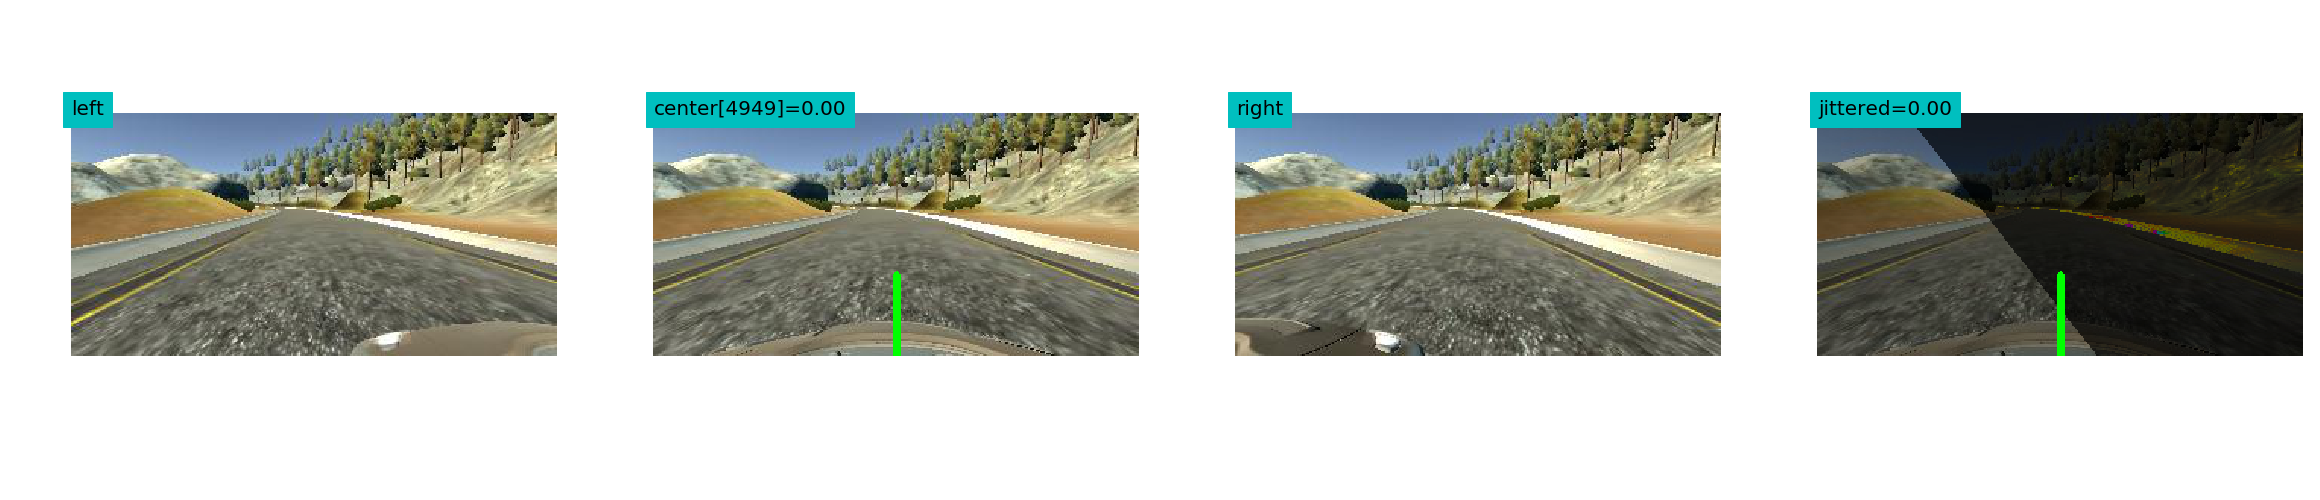

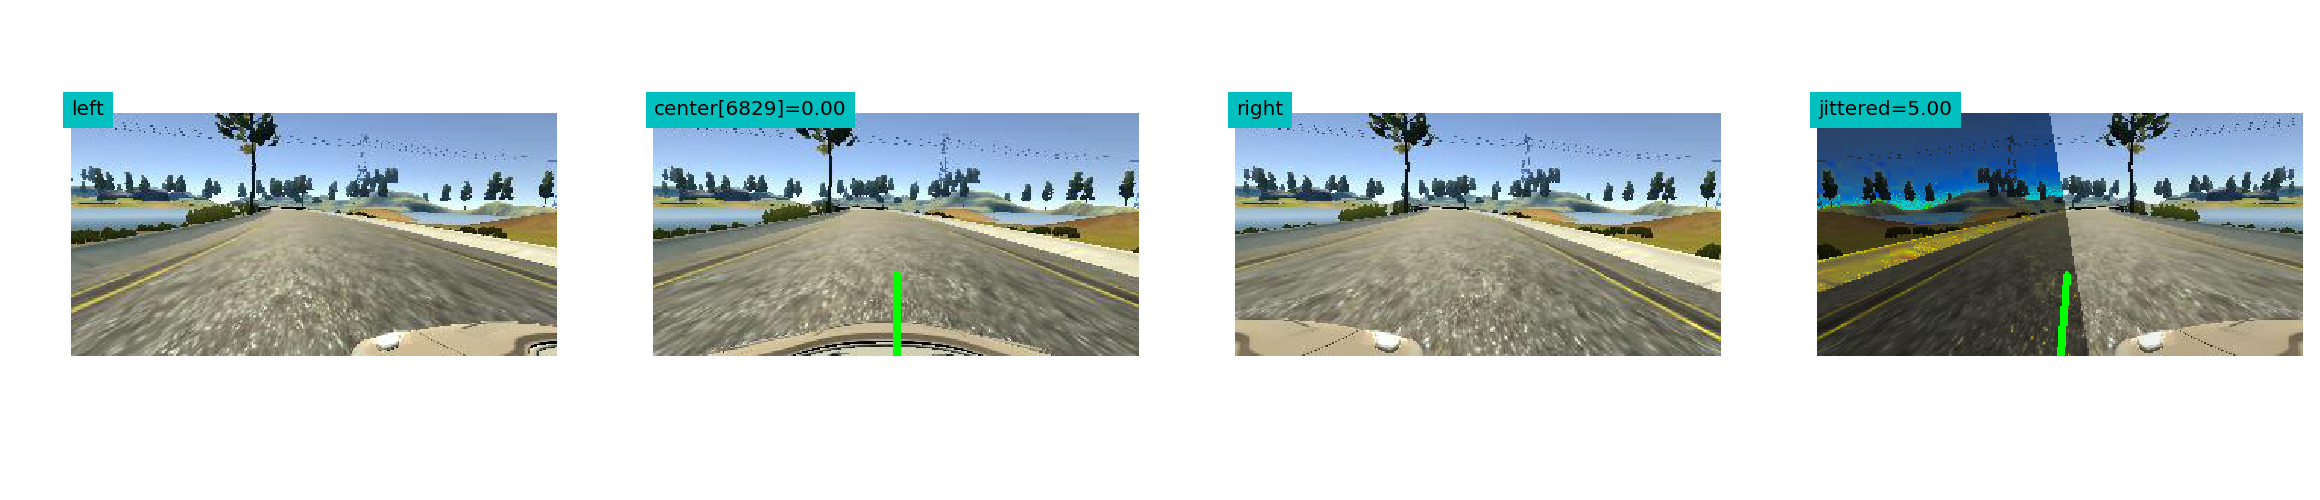

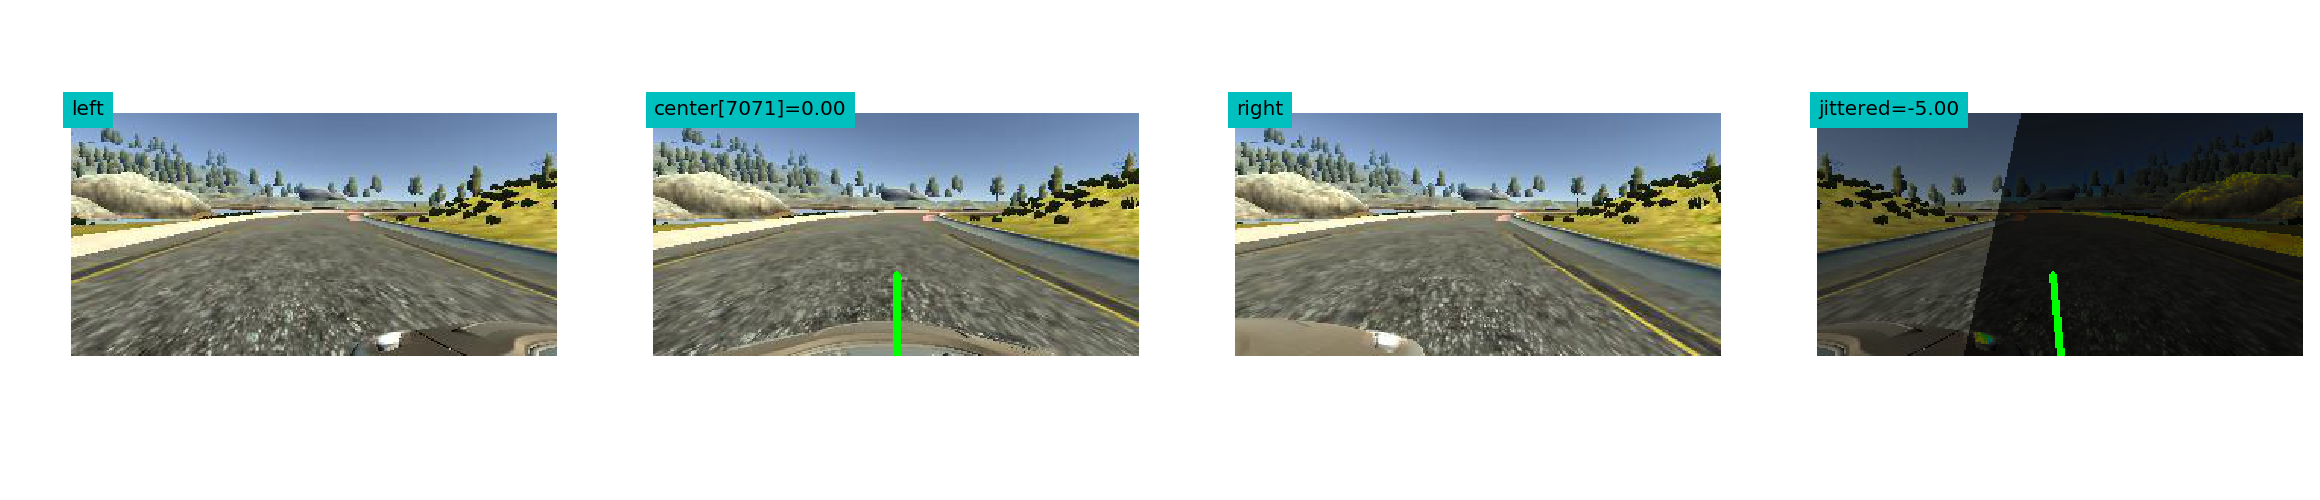

In [18]:
for i in range(3):
    idx = np.random.randint(udacity_dlog.shape[0])
    visualize_aug(idx)

## Model architecture

### NVIDIA architecture

First let's try NVIDIA architecture

In [54]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, Lambda, Cropping2D
from keras.optimizers import Adam
from keras import regularizers, callbacks, initializers

def build_nvidia(input_shape, kinit = 'he_normal'):
    model = Sequential()
    
    # simple normalization
    model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=input_shape, name='normalize'))
    
    # first 3 conv-layers use kernel (5, 5) with stride (2, 2)
    # filters-depths are [24, 36, 48]
    filter_depths = [24, 36, 48]
    layer = 1
    for d in filter_depths:
        model.add(Conv2D(d, 5, strides=(2, 2), activation='elu', padding='valid',
                         name='conv{}'.format(layer), kernel_initializer = kinit))
        layer += 1
    
    # the last 2 conv-layers use kernel (3, 3) with stride (1, 1)
    filter_depths = [64, 64]
    for d in filter_depths:
        model.add(Conv2D(d, 3, strides=(1, 1), activation='elu', padding='valid',
                         name='conv{}'.format(layer), kernel_initializer = kinit))
        layer += 1
    
    # flatten
    model.add(Flatten(name='flatten'))
    model.add(Dropout(0.5, name = 'dropout_conv'))
    
    # fully-connected layers
    hidden_dims = [100, 50, 10]
    layer = 1
    for h in hidden_dims:
        model.add(Dense(h, activation = 'elu', kernel_initializer = kinit,
                        name='hidden{}'.format(layer)))
        
        #model.add(Dropout(0.5, name='dropout_h{}'.format(layer)))
        
        layer += 1
        
    
    # output-regressor
    model.add(Dense(1, name='output', kernel_initializer=kinit))
    
    return model

def train_model(model, train_data_gen, valid_data_gen, 
                steps_per_epoch, validation_steps, epochs, 
                learning_rate = 1e-3,
                save_file = 'model.h5',
                best_file = 'model_best.h5'):
    optimizer = Adam(lr = learning_rate)
    model.compile(loss='mse', optimizer=optimizer)
    
    save_best = callbacks.ModelCheckpoint(best_file, save_best_only=True)
    # train-loop
    model.fit_generator(train_data_gen, steps_per_epoch, epochs, 
                        validation_data=valid_data_gen,
                        validation_steps=validation_steps,
                        callbacks = [save_best])
    
    # save trained model
    model.save(save_file)

In [55]:
def get_next_train_data(dataset, row_idx, use_multiple_camera, correction):
    if use_multiple_camera:
        return multiple_camera(dataset[['left', 'center', 'right']].values[row_idx],
                               dataset[['steering']].values[row_idx],
                               correction)
    else:
        return dataset[['center', 'steering']].values[row_idx]
    

def train_generator(dataset, input_size, batch_size, correction, use_multiple_camera = True):
    num_samples = dataset.shape[0]
    inputs  = np.zeros((batch_size, *input_size), dtype=np.uint8)
    targets = np.zeros((batch_size), dtype = np.float32)
    
    while 1:        
            
        for i in range(batch_size):
            
            row_idx = np.random.randint(num_samples)
            img, steering = get_next_train_data(dataset, 
                                                row_idx, 
                                                use_multiple_camera, 
                                                correction)

            img, targets[i] = get_jittered_data(img, steering)
            inputs[i] = preprocess(img)

        yield inputs, targets
        
def valid_generator(dataset, input_size, batch_size):
    num_samples = dataset.shape[0]
    
    inputs  = np.zeros((batch_size, *input_size), dtype=np.uint8)
    targets = np.zeros((batch_size), dtype = np.float32)
    
    steps_per_epoch = num_samples // batch_size 
    
    while 1:
        for i in range(steps_per_epoch):
            offest = i * batch_size
            for j in range(batch_size):
                img, steering = mpimg.imread(dataset['center'][offest + j]), dataset['steering'][offest + j]
                inputs[j] =  preprocess(img)
                targets[j] = steering
            
            yield inputs, targets        

#### Train with NVIDIA architecture

We are ready to build/train our model

In [56]:
input_shape = (66,200,3)
nvidia_model = build_nvidia(input_shape, kinit = 'glorot_uniform')
nvidia_model.summary()

CORRECTION = 0.20
batch_size = 32

train_gen = train_generator(train, input_shape, batch_size, CORRECTION, True)
valid_gen = valid_generator(valid, input_shape, batch_size)

      
steps_per_epoch = train.shape[0] // batch_size
validation_steps = valid.shape[0] // batch_size

learning_rate = 1e-4
train_model(nvidia_model, train_gen, valid_gen, steps_per_epoch, validation_steps, 
            epochs=10, learning_rate=learning_rate,
            save_file = 'model_cor={:.2f}.h5'.format(CORRECTION),
            best_file = 'model_cor={:.2f}_best.h5'.format(CORRECTION))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 66, 200, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 47, 36)        21636     
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 22, 48)         43248     
_________________________________________________________________
conv4 (Conv2D)               (None, 3, 20, 64)         27712     
_________________________________________________________________
conv5 (Conv2D)               (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
__________

#### Re-train model
Using above model, we run it in automatic-mode and we allow to adjust the model using joystick (via pygame), we save these image in manual folder so we can re-train the model with these images

min angle -0.507812
max angle 0.8739620000000001
number of positive 1238
number of negative 3288
                                   center  steering
0  manual/IMG/2017_07_28_22_36_50_189.jpg -0.046875
1  manual/IMG/2017_07_28_22_36_50_206.jpg -0.054688
2  manual/IMG/2017_07_28_22_36_50_223.jpg -0.054688


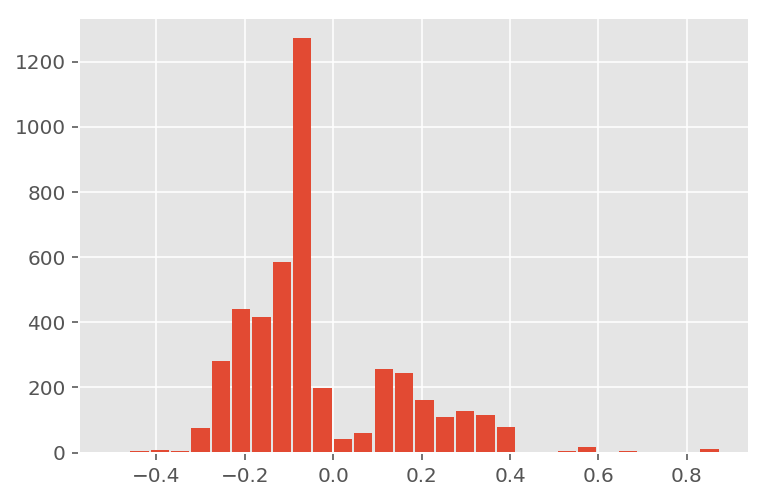

In [152]:
manual_dir = 'manual'
manual_dc = DataConverter(manual_dir)
manual_dlog = pd.read_csv(os.path.join(manual_dir, 'driving_log.csv'), 
                           converters = {'center' : manual_dc})

steering_hist(manual_dlog['steering'].values)  

print(manual_dlog[:3])

In [153]:
from keras.models import load_model

retrain_model = load_model('model.h5.03')

steps_per_epoch = manual_dlog.shape[0] // batch_size
validation_steps = test.shape[0] // batch_size
manual_gen = data_generator(manual_dlog, input_shape, True, False,   batch_size, CORRECTION, EPS)
test_gen = data_generator(test, input_shape, False, False, batch_size, CORRECTION, EPS)
learning_rate = 1e-5
train_model(retrain_model, manual_gen, test_gen, steps_per_epoch, validation_steps, 
            epochs=10, 
            learning_rate=learning_rate)

Epoch 1/10
70/70 [==============================] - 15s - loss: 0.0161 - val_loss: 0.0127
Epoch 2/10
70/70 [==============================] - 11s - loss: 0.0162 - val_loss: 0.0113
Epoch 3/10
70/70 [==============================] - 12s - loss: 0.0155 - val_loss: 0.0116
Epoch 4/10
70/70 [==============================] - 12s - loss: 0.0160 - val_loss: 0.0098
Epoch 5/10
70/70 [==============================] - 12s - loss: 0.0155 - val_loss: 0.0103
Epoch 6/10
70/70 [==============================] - 12s - loss: 0.0158 - val_loss: 0.0121
Epoch 7/10
70/70 [==============================] - 12s - loss: 0.0156 - val_loss: 0.0097
Epoch 8/10
70/70 [==============================] - 12s - loss: 0.0154 - val_loss: 0.0116
Epoch 9/10
70/70 [==============================] - 12s - loss: 0.0149 - val_loss: 0.0127
Epoch 10/10
70/70 [==============================] - 12s - loss: 0.0149 - val_loss: 0.0121
